# LightGBM Classifier training

- To reproduce these results, attach this notebook to a cluster with runtime version **14.3.x-gpu-ml-scala2.12**, and rerun it.

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "Attack_type"

## Load Data

In [0]:
import mlflow
import os
import uuid
import shutil
import pandas as pd

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)


# Download the artifact and read it into a pandas DataFrame
input_data_path = mlflow.artifacts.download_artifacts(run_id="c564698cbc364ebc8a12142001318d0f", artifact_path="data", dst_path=input_temp_dir)

df_loaded = pd.read_parquet(os.path.join(input_data_path, "training_data"))
# Delete the temp data
shutil.rmtree(input_temp_dir)

attacks = ['DOS_SYN_Hping', 'Thing_Speak', 'ARP_poisioning', 'MQTT_Publish', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN', 'Wipro_bulb']
df_loaded = df_loaded[df_loaded['Attack_type'].isin(attacks)]
# Preview data
df_loaded.head(5)

,fwd_init_window_size,id_resp_p,fwd_pkts_payload_avg,fwd_pkts_payload_min,fwd_URG_flag_count,flow_SYN_flag_count,fwd_header_size_min,fwd_header_size_max,flow_pkts_payload_tot,flow_pkts_payload_max,flow_iat_min,payload_bytes_per_second,fwd_last_window_size,id_orig_p,fwd_pkts_payload_max,flow_FIN_flag_count,active_min,flow_pkts_payload_avg,bwd_pkts_per_sec,bwd_pkts_payload_avg,flow_pkts_per_sec,fwd_header_size_tot,bwd_header_size_max,fwd_iat_min,fwd_pkts_per_sec,fwd_pkts_payload_tot,active_avg,flow_pkts_payload_min,service_dhcp,service_dns,service_http,service_irc,service_mqtt,service_ntp,service_radius,service_ssl,service_unspec,proto_icmp,proto_tcp,proto_udp,Attack_type,_automl_sample_weight_0000,_automl_split_col_0000
0,0.000852,0.000494,0.091159,0.108806,0.0,0.125100,0.454561,0.384658,0.000000,0.022813,0.000015,0.999764,0.001262,0.366978,0.083999,0.0,0.000137,0.051293,1.000000,0.000032,1.000000,0.000259,0.454681,0.000166,0.999202,0.000000,0.000099,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,DOS_SYN_Hping,2.569021,train
1,0.980453,0.031954,0.005078,0.000000,0.0,0.249576,0.728502,0.768118,0.000000,0.002692,0.000407,0.000180,0.007324,0.809176,0.021165,0.0,0.007562,0.006103,0.000799,0.004731,0.000000,0.004169,0.909680,0.000000,0.000000,0.000000,0.004900,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,MQTT_Publish,1.000000,train
2,0.000000,0.000905,0.023122,0.028026,0.0,0.000000,0.181137,0.152429,0.000000,0.008663,0.000255,0.001208,0.000000,0.910587,0.022730,0.0,0.000000,0.036254,0.000978,0.000000,0.000464,0.000000,0.000868,0.000000,0.000000,0.000000,0.000088,0.029792,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Wipro_bulb,1.000000,train
3,0.000429,0.000606,0.090434,0.108843,0.0,0.124632,0.454654,0.384046,0.000072,0.023237,0.000210,0.192132,0.000506,0.467166,0.084667,0.0,0.000000,0.052093,0.192117,0.000000,0.251505,0.000492,0.454363,0.000000,0.193913,0.000034,0.000092,0.000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,DOS_SYN_Hping,2.569021,train
4,0.001064,0.000113,0.090298,0.108259,0.0,0.124752,0.454220,0.384770,0.000140,0.022642,0.000000,0.188247,0.000785,0.186979,0.083663,0.0,0.000000,0.050946,0.189045,0.000000,0.191182,0.000544,0.454226,0.000000,0.190283,0.000113,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,DOS_SYN_Hping,2.569021,train


### Select supported columns
Select only the columns that are supported. This allows us to train a model that can predict on a dataset that has extra columns that are not used in training.
`[]` are dropped in the pipelines. See the Alerts tab of the AutoML Experiment page for details on why these columns are dropped.

In [0]:
from databricks.automl_runtime.sklearn.column_selector import ColumnSelector
supported_cols = ["active_avg", "service_radius", "id_resp_p", "fwd_pkts_per_sec", "fwd_pkts_payload_avg", "id_orig_p", "flow_pkts_payload_tot", "service_dns", "fwd_header_size_tot", "service_dhcp", "flow_pkts_payload_min", "bwd_pkts_per_sec", "flow_pkts_per_sec", "active_min", "service_http", "fwd_header_size_max", "flow_pkts_payload_max", "bwd_pkts_payload_avg", "proto_tcp", "flow_SYN_flag_count", "service_mqtt", "fwd_header_size_min", "bwd_header_size_max", "fwd_pkts_payload_min", "fwd_iat_min", "service_unspec", "proto_udp", "flow_pkts_payload_avg", "fwd_URG_flag_count", "proto_icmp", "service_ssl", "flow_iat_min", "fwd_pkts_payload_tot", "fwd_last_window_size", "service_irc", "flow_FIN_flag_count", "payload_bytes_per_second", "fwd_init_window_size", "fwd_pkts_payload_max", "service_ntp"]
col_selector = ColumnSelector(supported_cols)

## Preprocessors

### Boolean columns
For each column, impute missing values and then convert into ones and zeros.

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder


bool_imputers = []

bool_pipeline = Pipeline(steps=[
    ("cast_type", FunctionTransformer(lambda df: df.astype(object))),
    ("imputers", ColumnTransformer(bool_imputers, remainder="passthrough")),
    ("onehot", SklearnOneHotEncoder(handle_unknown="ignore", drop="first")),
])

bool_transformers = [("boolean", bool_pipeline, ["proto_udp", "service_http", "service_irc", "fwd_URG_flag_count", "service_radius", "proto_icmp", "service_ssl", "service_dns", "proto_tcp", "service_mqtt", "service_dhcp", "service_ntp", "service_unspec"])]

### Numerical columns

Missing values for numerical columns are imputed with mean by default.

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

num_imputers = []
num_imputers.append(("impute_mean", SimpleImputer(), ["active_avg", "active_min", "bwd_header_size_max", "bwd_pkts_payload_avg", "bwd_pkts_per_sec", "flow_FIN_flag_count", "flow_SYN_flag_count", "flow_iat_min", "flow_pkts_payload_avg", "flow_pkts_payload_max", "flow_pkts_payload_min", "flow_pkts_payload_tot", "flow_pkts_per_sec", "fwd_URG_flag_count", "fwd_header_size_max", "fwd_header_size_min", "fwd_header_size_tot", "fwd_iat_min", "fwd_init_window_size", "fwd_last_window_size", "fwd_pkts_payload_avg", "fwd_pkts_payload_max", "fwd_pkts_payload_min", "fwd_pkts_payload_tot", "fwd_pkts_per_sec", "id_orig_p", "id_resp_p", "payload_bytes_per_second", "proto_icmp", "proto_tcp", "proto_udp", "service_dhcp", "service_dns", "service_http", "service_irc", "service_mqtt", "service_ntp", "service_radius", "service_ssl", "service_unspec"]))

numerical_pipeline = Pipeline(steps=[
    ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors='coerce'))),
    ("imputers", ColumnTransformer(num_imputers)),
    ("standardizer", StandardScaler()),
])

numerical_transformers = [("numerical", numerical_pipeline, ["active_avg", "id_resp_p", "fwd_pkts_payload_avg", "fwd_pkts_per_sec", "id_orig_p", "service_radius", "flow_pkts_payload_tot", "service_dns", "fwd_header_size_tot", "service_dhcp", "flow_pkts_payload_min", "bwd_pkts_per_sec", "flow_pkts_per_sec", "active_min", "service_http", "fwd_header_size_max", "flow_pkts_payload_max", "bwd_pkts_payload_avg", "flow_SYN_flag_count", "proto_tcp", "fwd_header_size_min", "service_mqtt", "bwd_header_size_max", "fwd_pkts_payload_min", "fwd_iat_min", "service_unspec", "flow_pkts_payload_avg", "proto_udp", "fwd_URG_flag_count", "proto_icmp", "service_ssl", "flow_iat_min", "fwd_pkts_payload_tot", "fwd_last_window_size", "service_irc", "flow_FIN_flag_count", "payload_bytes_per_second", "fwd_init_window_size", "fwd_pkts_payload_max", "service_ntp"])]

In [0]:
from sklearn.compose import ColumnTransformer

transformers = bool_transformers + numerical_transformers

preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=0)

## Train - Validation - Test Split
The input data is split by AutoML into 3 sets:
- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters of the model)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

`_automl_split_col_0000` contains the information of which set a given row belongs to.
We use this column to split the dataset into the above 3 sets. 
The column should not be used for training so it is dropped after split is done.

In [0]:
# AutoML completed train - validation - test split internally and used _automl_split_col_0000 to specify the set
split_train_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "train"]
split_val_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "val"]
split_test_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "test"]

# Separate target column from features and drop _automl_split_col_0000
X_train = split_train_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_train = split_train_df[target_col]

X_val = split_val_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_val = split_val_df[target_col]

X_test = split_test_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_test = split_test_df[target_col]

In [0]:
# AutoML balanced the data internally and use _automl_sample_weight_0000 to calibrate the probability distribution
sample_weight = X_train.loc[:, "_automl_sample_weight_0000"].to_numpy()
X_train = X_train.drop(["_automl_sample_weight_0000"], axis=1)
X_val = X_val.drop(["_automl_sample_weight_0000"], axis=1)
X_test = X_test.drop(["_automl_sample_weight_0000"], axis=1)

## Train classification model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/1409232751952184)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment
- To view the full list of tunable hyperparameters, check the output of the cell below

In [0]:
import lightgbm
from lightgbm import LGBMClassifier

help(LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(sklearn.base.ClassifierMixin, LGBMModel)
 |  LGBMClassifier(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable[[Optional[numpy.ndarray], numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray], Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.RandomS

### Define the objective function
The objective function used to find optimal hyperparameters. By default, this notebook only runs
this function once (`max_evals=1` in the `hyperopt.fmin` invocation) with fixed hyperparameters, but
hyperparameters can be tuned by modifying `space`, defined below. `hyperopt.fmin` will then use this
function's return value to search the space to minimize the loss.

In [0]:
import mlflow
from mlflow.models import Model, infer_signature, ModelSignature
from mlflow.pyfunc import PyFuncModel
from mlflow import pyfunc
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline

from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

# Create a separate pipeline to transform the validation dataset. This is used for early stopping.
mlflow.sklearn.autolog(disable=True)
pipeline_val = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
])
pipeline_val.fit(X_train, y_train)
X_val_processed = pipeline_val.transform(X_val)

def objective(params):
  with mlflow.start_run(experiment_id="1409232751952184") as mlflow_run:
    lgbmc_classifier = LGBMClassifier(**params)

    model = Pipeline([
        ("column_selector", col_selector),
        ("preprocessor", preprocessor),
        ("classifier", lgbmc_classifier),
    ])

    # Enable automatic logging of input samples, metrics, parameters, and models
    mlflow.sklearn.autolog(
        log_input_examples=True,
        silent=True)

    model.fit(X_train, y_train, classifier__callbacks=[lightgbm.early_stopping(5), lightgbm.log_evaluation(0)], classifier__eval_set=[(X_val_processed,y_val)], classifier__sample_weight=sample_weight)

    
    # Log metrics for the training set
    mlflow_model = Model()
    pyfunc.add_to_model(mlflow_model, loader_module="mlflow.sklearn")
    pyfunc_model = PyFuncModel(model_meta=mlflow_model, model_impl=model)
    training_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_train.assign(**{str(target_col):y_train}),
        targets=target_col,
        model_type="classifier",
        evaluator_config = {"log_model_explainability": False,
                            "metric_prefix": "training_" , "sample_weight": sample_weight }
    )
    lgbmc_training_metrics = training_eval_result.metrics
    # Log metrics for the validation set
    val_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_val.assign(**{str(target_col):y_val}),
        targets=target_col,
        model_type="classifier",
        evaluator_config = {"log_model_explainability": False,
                            "metric_prefix": "val_"  }
    )
    lgbmc_val_metrics = val_eval_result.metrics
    # Log metrics for the test set
    test_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_test.assign(**{str(target_col):y_test}),
        targets=target_col,
        model_type="classifier",
        evaluator_config = {"log_model_explainability": False,
                            "metric_prefix": "test_"  }
    )
    lgbmc_test_metrics = test_eval_result.metrics

    loss = -lgbmc_val_metrics["val_f1_score"]

    # Truncate metric key names so they can be displayed together
    lgbmc_val_metrics = {k.replace("val_", ""): v for k, v in lgbmc_val_metrics.items()}
    lgbmc_test_metrics = {k.replace("test_", ""): v for k, v in lgbmc_test_metrics.items()}

    return {
      "loss": loss,
      "status": STATUS_OK,
      "val_metrics": lgbmc_val_metrics,
      "test_metrics": lgbmc_test_metrics,
      "model": model,
      "run": mlflow_run,
    }

### Configure the hyperparameter search space
Configure the search space of parameters. Parameters below are all constant expressions but can be
modified to widen the search space. For example, when training a decision tree classifier, to allow
the maximum tree depth to be either 2 or 3, set the key of 'max_depth' to
`hp.choice('max_depth', [2, 3])`. Be sure to also increase `max_evals` in the `fmin` call below.

See https://docs.databricks.com/applications/machine-learning/automl-hyperparam-tuning/index.html
for more information on hyperparameter tuning as well as
http://hyperopt.github.io/hyperopt/getting-started/search_spaces/ for documentation on supported
search expressions.

For documentation on parameters used by the model in use, please see:
https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMClassifier.html

NOTE: The above URL points to a stable version of the documentation corresponding to the last
released version of the package. The documentation may differ slightly for the package version
used by this notebook.

In [0]:
space = {
  "colsample_bytree": 0.6508428909940092,
  "lambda_l1": 4.257968453073029,
  "lambda_l2": 3.2451254279815167,
  "learning_rate": 0.04713902452031374,
  "max_bin": 496,
  "max_depth": 9,
  "min_child_samples": 193,
  "n_estimators": 234,
  "num_leaves": 6,
  "path_smooth": 11.777740826576233,
  "subsample": 0.519869678894217,
  "random_state": 511145318,
}

### Run trials
When widening the search space and training multiple models, switch to `SparkTrials` to parallelize
training on Spark:
```
from hyperopt import SparkTrials
trials = SparkTrials()
```

NOTE: While `Trials` starts an MLFlow run for each set of hyperparameters, `SparkTrials` only starts
one top-level run; it will start a subrun for each set of hyperparameters.

See http://hyperopt.github.io/hyperopt/scaleout/spark/ for more info.

[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13457
[LightGBM] [Info] Number of data points in the train set: 196457, number of used features: 53
[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

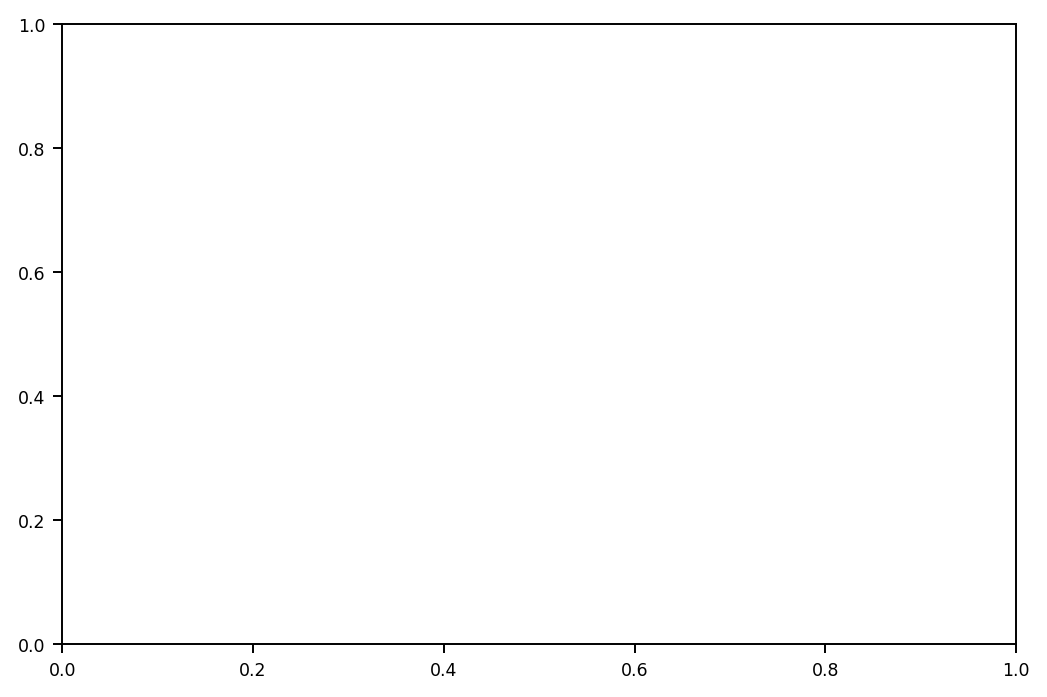

Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
  0%|          | 0/1 [02:45<?, ?trial/s, best loss=?]

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

2024/04/04 15:47:09 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.

2024/04/04 15:47:09 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.



[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
  0%|          | 0/1 [02:59<?, ?trial/s, best loss=?]

2024/04/04 15:47:18 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as multiclass dataset, number of classes is inferred as 7



[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
  0%|          | 0/1 [03:07<?, ?trial/s, best loss=?]

2024/04/04 15:47:31 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...

2024/04/04 15:47:40 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.

2024/04/04 15:47:40 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.



[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
  0%|          | 0/1 [03:27<?, ?trial/s, best loss=?]

<Figure size 1050x700 with 0 Axes>

2024/04/04 15:47:44 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as multiclass dataset, number of classes is inferred as 7



[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
  0%|          | 0/1 [03:31<?, ?trial/s, best loss=?]

2024/04/04 15:47:51 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...

2024/04/04 15:47:58 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.

2024/04/04 15:47:58 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.



[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
  0%|          | 0/1 [03:45<?, ?trial/s, best loss=?]

2024/04/04 15:48:02 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as multiclass dataset, number of classes is inferred as 7



[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029
  0%|          | 0/1 [03:49<?, ?trial/s, best loss=?]

2024/04/04 15:48:09 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...



100%|██████████| 1/1 [03:59<00:00, 239.71s/trial, best loss: -0.9390740764791553]


<Figure size 1050x700 with 0 Axes>

score,example_count,accuracy_score,recall_score,precision_score,f1_score,log_loss,roc_auc
0.9391529131039968,95551,0.9391529131039968,0.9391529131039968,0.9393575202811897,0.9390740764791553,0.17406515995806476,0.9950828392930479
0.9399789251844046,94900,0.9399789251844046,0.9399789251844046,0.9401725528851702,0.9399014182945258,0.1737040217655537,0.9951512307503511


Pipeline(steps=[('column_selector',
                 ColumnSelector(cols=['active_avg', 'service_radius',
                                      'id_resp_p', 'fwd_pkts_per_sec',
                                      'fwd_pkts_payload_avg', 'id_orig_p',
                                      'flow_pkts_payload_tot', 'service_dns',
                                      'fwd_header_size_tot', 'service_dhcp',
                                      'flow_pkts_payload_min',
                                      'bwd_pkts_per_sec', 'flow_pkts_per_sec',
                                      'active_min', 'service_http',
                                      'fwd_header_size_max',
                                      'flow_pkts...
                                                   'fwd_URG_flag_count',
                                                   'proto_icmp', ...])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.6508428909940092,
                                lambda_l1=4.257968453073029,
                                lambda_l2=3.2451254279815167,
                                learning_rate=0.04713902452031374, max_bin=496,
                                max_depth=9, min_child_samples=193,
                                n_estimators=234, num_leaves=6,
                                path_smooth=11.777740826576233,
                                random_state=511145318,
                                subsample=0.519869678894217))])

In [0]:
trials = Trials()
fmin(objective,
     space=space,
     algo=tpe.suggest,
     max_evals=1,  # Increase this when widening the hyperparameter search space.
     trials=trials)

best_result = trials.best_trial["result"]
model = best_result["model"]
mlflow_run = best_result["run"]

display(
  pd.DataFrame(
    [best_result["val_metrics"], best_result["test_metrics"]],
    index=["validation", "test"]))

set_config(display="diagram")
model

### Patch pandas version in logged model

Ensures that model serving uses the same version of pandas that was used to train the model.

In [0]:
import mlflow
import os
import shutil
import tempfile
import yaml

run_id = mlflow_run.info.run_id

# Set up a local dir for downloading the artifacts.
tmp_dir = tempfile.mkdtemp()

client = mlflow.tracking.MlflowClient()

# Fix conda.yaml
conda_file_path = mlflow.artifacts.download_artifacts(artifact_uri=f"runs:/{run_id}/model/conda.yaml", dst_path=tmp_dir)
with open(conda_file_path) as f:
  conda_libs = yaml.load(f, Loader=yaml.FullLoader)
pandas_lib_exists = any([lib.startswith("pandas==") for lib in conda_libs["dependencies"][-1]["pip"]])
if not pandas_lib_exists:
  print("Adding pandas dependency to conda.yaml")
  conda_libs["dependencies"][-1]["pip"].append(f"pandas=={pd.__version__}")

  with open(f"{tmp_dir}/conda.yaml", "w") as f:
    f.write(yaml.dump(conda_libs))
  client.log_artifact(run_id=run_id, local_path=conda_file_path, artifact_path="model")

# Fix requirements.txt
venv_file_path = mlflow.artifacts.download_artifacts(artifact_uri=f"runs:/{run_id}/model/requirements.txt", dst_path=tmp_dir)
with open(venv_file_path) as f:
  venv_libs = f.readlines()
venv_libs = [lib.strip() for lib in venv_libs]
pandas_lib_exists = any([lib.startswith("pandas==") for lib in venv_libs])
if not pandas_lib_exists:
  print("Adding pandas dependency to requirements.txt")
  venv_libs.append(f"pandas=={pd.__version__}")

  with open(f"{tmp_dir}/requirements.txt", "w") as f:
    f.write("\n".join(venv_libs))
  client.log_artifact(run_id=run_id, local_path=venv_file_path, artifact_path="model")

shutil.rmtree(tmp_dir)

Adding pandas dependency to conda.yaml


Adding pandas dependency to requirements.txt


## Feature importance

SHAP is a game-theoretic approach to explain machine learning models, providing a summary plot
of the relationship between features and model output. Features are ranked in descending order of
importance, and impact/color describe the correlation between the feature and the target variable.
- Generating SHAP feature importance is a very memory intensive operation, so to ensure that AutoML can run trials without
  running out of memory, we disable SHAP by default.<br />
  You can set the flag defined below to `shap_enabled = True` and re-run this notebook to see the SHAP plots.
- To reduce the computational overhead of each trial, a single example is sampled from the validation set to explain.<br />
  For more thorough results, increase the sample size of explanations, or provide your own examples to explain.
- SHAP cannot explain models using data with nulls; if your dataset has any, both the background data and
  examples to explain will be imputed using the mode (most frequent values). This affects the computed
  SHAP values, as the imputed samples may not match the actual data distribution.

For more information on how to read Shapley values, see the [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

In [0]:
# Set this flag to True and re-run the notebook to see the SHAP plots
shap_enabled = True

In [0]:
if shap_enabled:
    mlflow.autolog(disable=True)
    mlflow.sklearn.autolog(disable=True)
    from shap import KernelExplainer, summary_plot
    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, X_train.shape[0]), random_state=511145318)

    # Sample some rows from the validation set to explain. Increase the sample size for more thorough results.
    example = X_val.sample(n=min(100, X_val.shape[0]), random_state=511145318)

    # Use Kernel SHAP to explain feature importance on the sampled rows from the validation set.
    predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="logit")
    shap_values = explainer.shap_values(example, l1_reg=False, nsamples=500)
    summary_plot(shap_values, example, class_names=model.classes_)

In [0]:
# Fit the validation pipeline on the training data
pipeline_val.fit(X_train, y_train)

# Manually set the feature names for the 'cast_type' step, assuming it just converts types without changing the number or order of features
cast_type_feature_names = ["proto_udp", "service_http", "service_irc", "fwd_URG_flag_count", "service_radius", "proto_icmp", "service_ssl", "service_dns", "proto_tcp", "service_mqtt", "service_dhcp", "service_ntp", "service_unspec"]

# Get the feature names for the one-hot encoded features
onehot_feature_names = pipeline_val.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out(cast_type_feature_names)

# Combine the one-hot encoded feature names with the numerical feature names
# Assuming numerical features are passed through as-is (since they are just scaled), append their original names
numerical_feature_names = ["active_avg", "id_resp_p", "fwd_pkts_payload_avg", "fwd_pkts_per_sec", "id_orig_p", "service_radius", "flow_pkts_payload_tot", "service_dns", "fwd_header_size_tot", "service_dhcp", "flow_pkts_payload_min", "bwd_pkts_per_sec", "flow_pkts_per_sec", "active_min", "service_http", "fwd_header_size_max", "flow_pkts_payload_max", "bwd_pkts_payload_avg", "flow_SYN_flag_count", "proto_tcp", "fwd_header_size_min", "service_mqtt", "bwd_header_size_max", "fwd_pkts_payload_min", "fwd_iat_min", "service_unspec", "flow_pkts_payload_avg", "proto_udp", "fwd_URG_flag_count", "proto_icmp", "service_ssl", "flow_iat_min", "fwd_pkts_payload_tot", "fwd_last_window_size", "service_irc", "flow_FIN_flag_count", "payload_bytes_per_second", "fwd_init_window_size", "fwd_pkts_payload_max", "service_ntp"]

# Combine all the feature names
all_feature_names = list(onehot_feature_names) + numerical_feature_names

# Print or store the column names as needed
print(all_feature_names)


Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

['proto_udp_1.0', 'service_http_1.0', 'service_irc_1.0', 'fwd_URG_flag_count_1.0', 'service_radius_1.0', 'proto_icmp_1.0', 'service_ssl_1.0', 'service_dns_1.0', 'proto_tcp_1.0', 'service_mqtt_1.0', 'service_dhcp_1.0', 'service_ntp_1.0', 'service_unspec_1.0', 'active_avg', 'id_resp_p', 'fwd_pkts_payload_avg', 'fwd_pkts_per_sec', 'id_orig_p', 'service_radius', 'flow_pkts_payload_tot', 'service_dns', 'fwd_header_size_tot', 'service_dhcp', 'flow_pkts_payload_min', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'active_min', 'service_http', 'fwd_header_size_max', 'flow_pkts_payload_max', 'bwd_pkts_payload_avg', 'flow_SYN_flag_count', 'proto_tcp', 'fwd_header_size_min', 'service_mqtt', 'bwd_header_size_max', 'fwd_pkts_payload_min', 'fwd_iat_min', 'service_unspec', 'flow_pkts_payload_avg', 'proto_udp', 'fwd_URG_flag_count', 'proto_icmp', 'service_ssl', 'flow_iat_min', 'fwd_pkts_payload_tot', 'fwd_last_window_size', 'service_irc', 'flow_FIN_flag_count', 'payload_bytes_per_second', 'fwd_init_window_s

In [0]:
pd.DataFrame(X_val_processed, columns=all_feature_names)

,proto_udp_1.0,service_http_1.0,service_irc_1.0,fwd_URG_flag_count_1.0,service_radius_1.0,proto_icmp_1.0,service_ssl_1.0,service_dns_1.0,proto_tcp_1.0,service_mqtt_1.0,service_dhcp_1.0,service_ntp_1.0,service_unspec_1.0,active_avg,id_resp_p,fwd_pkts_payload_avg,fwd_pkts_per_sec,id_orig_p,service_radius,flow_pkts_payload_tot,service_dns,fwd_header_size_tot,service_dhcp,flow_pkts_payload_min,bwd_pkts_per_sec,flow_pkts_per_sec,active_min,service_http,fwd_header_size_max,flow_pkts_payload_max,bwd_pkts_payload_avg,flow_SYN_flag_count,proto_tcp,fwd_header_size_min,service_mqtt,bwd_header_size_max,fwd_pkts_payload_min,fwd_iat_min,service_unspec,flow_pkts_payload_avg,proto_udp,fwd_URG_flag_count,proto_icmp,service_ssl,flow_iat_min,fwd_pkts_payload_tot,fwd_last_window_size,service_irc,flow_FIN_flag_count,payload_bytes_per_second,fwd_init_window_size,fwd_pkts_payload_max,service_ntp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.555987,-0.521615,0.100856,-0.466146,3.229579,-0.532722,1.408286,-0.595431,-0.316445,-0.262763,-0.590983,-0.318895,3.243262,-0.253495,1.508086,1.478830,1.163412,-0.338338,1.601728,-0.150437,-1.083632,0.252360,-0.928468,-0.223923,3.204923,-0.122810,-0.328483,3.274265,-0.168678,0.741508,-0.704786,-0.165961,-0.525658,-0.282587,-0.162364,-0.331173,-0.182033,-0.099763,-0.294542,-0.887990
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.555987,-0.521615,-1.299264,-0.478943,-0.500861,-0.530757,-1.029638,-0.595431,-0.414176,-0.554040,0.805811,-0.552830,-0.495269,-0.253495,-1.059363,-1.183896,-0.318082,-0.338338,-0.631551,-0.196989,-0.318838,-0.410299,-0.155236,-0.145031,-0.500780,1.267711,4.211433,-0.459024,-0.168678,-1.348603,1.418869,-0.165961,-0.525658,-0.282587,-0.162364,-0.331173,-0.182033,10.023758,-0.294542,-0.887990
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.436941,-0.313221,0.101967,-0.478943,2.478324,-0.532722,0.186820,-0.595431,-0.096342,-0.263595,-0.621307,-0.219919,3.241132,-0.253495,-0.094762,0.150419,-0.606137,-0.338338,-0.628572,-0.193069,1.194483,-0.017833,1.451830,-0.498400,3.195834,-1.263136,-0.330325,3.269730,-0.168678,0.741508,-0.704786,-0.165961,-0.525658,-0.282587,-0.162364,-0.331173,-0.182033,-0.099763,-0.294542,1.126139
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.406353,-0.521615,-1.299264,-0.478943,-0.504628,0.787198,-1.029638,-0.595431,-0.663466,-0.599197,-0.617126,-0.552830,-0.505200,-0.253495,-1.064570,0.151191,-0.703411,-0.137104,-0.628145,-0.196061,-1.125862,-0.585739,-0.937773,-0.331811,-0.500780,-0.344596,5.279038,-0.456035,-0.168678,-1.348603,-0.704786,-0.165961,-0.525658,-0.282587,-0.162364,-0.331173,-0.182033,-0.099763,-0.294542,1.126139
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.523354,-0.521615,-1.299264,-0.478943,-0.504628,-0.532722,-1.029638,0.328126,-0.318896,-0.430441,0.958469,-0.021111,-0.505200,-0.253495,-1.068471,-1.182365,-0.113443,-0.026134,-0.631551,-0.196989,-0.463612,-0.402077,-0.140684,0.335845,-0.500780,-0.264402,0.267514,-0.459024,-0.168678,-1.348603,1.418869,-0.165961,1.902377,-0.282587,-0.162364,-0.331173,-0.182033,-0.099763,-0.294542,-0.887990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95546,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.311967,-0.194604,-0.735263,0.640533,-0.504628,-0.532722,-1.029638,0.252172,-0.086431,-0.162314,0.446337,-0.552830,-0.505200,-0.253495,-1.055831,-1.179836,-0.518348,0.054493,-0.631551,-0.196989,-0.491349,-0.450480,-0.302976,-0.522698,-0.500780,1.071079,-0.323225,-0.459024,-0.168678,-1.348603,1.418869,-0.165961,1.902377,-0.282587,-0.162364,-0.331173,-0.182033,-0.099763,-0.294542,-0.887990
95547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.555987,-0.521615,0.101542,-0.478943,1.358373,-0.532722,0.188149,-0.595431,-0.090733,-0.263120,-0.621307,-0.552830,1.367164,-0.253495,-0.098148,0.153259,-

In [0]:
# Creating a DataFrame for each class and concatenating them
df_list = []
for class_index, class_shap_values in enumerate(shap_values):
    class_df = pd.DataFrame(class_shap_values, columns=all_feature_names)
    # Use the label_dict to get the corresponding label name for the class index
    class_label = label_dict[class_index]
    class_df['class'] = class_label  # Assign the label name instead of the class index
    df_list.append(class_df)

# Concatenate all DataFrames
shap_df = pd.concat(df_list, ignore_index=True)
shap_df

,proto_udp_1.0,service_http_1.0,service_irc_1.0,fwd_URG_flag_count_1.0,service_radius_1.0,proto_icmp_1.0,service_ssl_1.0,service_dns_1.0,proto_tcp_1.0,service_mqtt_1.0,service_dhcp_1.0,service_ntp_1.0,service_unspec_1.0,active_avg,id_resp_p,fwd_pkts_payload_avg,fwd_pkts_per_sec,id_orig_p,service_radius,flow_pkts_payload_tot,service_dns,fwd_header_size_tot,service_dhcp,flow_pkts_payload_min,bwd_pkts_per_sec,flow_pkts_per_sec,active_min,service_http,fwd_header_size_max,flow_pkts_payload_max,bwd_pkts_payload_avg,flow_SYN_flag_count,proto_tcp,fwd_header_size_min,service_mqtt,bwd_header_size_max,fwd_pkts_payload_min,fwd_iat_min,service_unspec,flow_pkts_payload_avg,proto_udp,fwd_URG_flag_count,proto_icmp,service_ssl,flow_iat_min,fwd_pkts_payload_tot,fwd_last_window_size,service_irc,flow_FIN_flag_count,payload_bytes_per_second,fwd_init_window_size,fwd_pkts_payload_max,service_ntp,class
0,-0.018918,0.008898,0.000000,0.0,0.002151,0.000000,-0.034127,-0.077884,-0.085051,0.0,-0.008937,0.013636,0.092579,0.087572,0.127981,-0.013583,-0.095643,-0.094944,-0.001101,0.001401,-0.061553,-0.054553,-0.038269,-0.164349,0.003261,-0.023365,0.0,-0.011750,0.024244,0.213949,0.000512,-0.022974,0.136121,-0.099538,-0.105027,0.243316,0.019652,-0.160132,-0.013872,-0.017636,-0.109317,0.000000,-0.049911,-0.007907,-0.004391,-0.029516,0.000000,0.000000,0.000000,0.002172,0.000391,0.000188,0.001100,ARP_poisioning
1,0.042822,0.003528,0.000000,0.0,-0.215851,0.000000,-0.009703,-0.172486,0.210502,0.0,-0.009944,0.045532,0.141297,0.080361,0.142021,0.044296,-0.122170,0.044605,-0.000023,-0.002279,-0.084198,-0.055502,0.025749,0.263713,0.003335,0.010171,0.0,-0.021082,-0.024560,0.198803,0.000716,0.012790,-0.029237,0.063079,0.118291,0.334687,0.131612,0.053572,-0.032540,-0.046082,-0.013705,0.000000,0.118650,0.010920,-0.002183,-0.139921,0.000000,0.000000,0.000000,0.004798,-0.041711,0.000188,0.001065,ARP_poisioning
2,-0.022434,0.002826,0.000000,0.0,0.002016,0.000000,-0.022483,-0.083167,-0.085732,0.0,-0.009290,0.007722,-0.164174,0.040748,0.051490,-0.010235,-0.112909,-0.073665,-0.001101,0.001514,-0.080928,-0.043969,-0.056780,-0.177488,0.003695,-0.023346,0.0,-0.015063,-0.010398,-0.244479,0.000512,0.009111,-0.025500,-0.001885,-0.119630,-0.532846,-0.245321,-0.177505,-0.013314,-0.021656,-0.112937,0.000000,-0.050791,-0.014082,-0.002578,-0.033198,0.000000,0.000000,0.000000,0.001953,0.000365,0.000188,-0.003346,ARP_poisioning
3,-0.018917,0.003528,0.000000,0.0,0.002065,0.000000,-0.009703,-0.100960,0.155592,0.0,-0.019377,0.013148,-0.156344,0.048456,0.087572,0.032912,-0.160802,0.013860,-0.000117,-0.007220,-0.085725,-0.018704,0.042881,-0.249485,0.003481,0.009597,0.0,0.033659,-0.017444,-0.292092,-0.006529,0.010034,-0.027042,-0.071462,0.049730,0.223850,-0.073796,0.043102,-0.007042,-0.049310,0.089248,0.000000,0.092375,-0.013158,-0.005981,-0.037585,0.000000,0.000000,0.000000,0.002172,0.000410,0.000188,-0.006121,ARP_poisioning
4,0.087468,0.007288,0.000000,0.0,0.002231,0.000000,-0.009703,0.424842,0.204349,0.0,-0.007430,0.051863,0.136588,0.085265,0.169558,0.051365,-0.045694,0.018949,0.001088,-0.010057,0.130665,-0.015931,0.093348,0.472522,0.001832,0.010604,0.0,0.124466,-0.014193,0.284904,-0.003136,0.011321,-0.028402,0.083166,0.158433,0.477446,0.318726,0.056095,-0.016046,0.104892,-0.006198,0.000000,0.173508,0.024335,-0.002183,0.135235,0.000000,0.000000,0.000000,0.009700,0.000451,0.000188,0.003226,ARP_poisioning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668852,0.000000,0.016468,-0.010848,0.0,0.000000,-0.007391,-0.012677,0.000000,0.043597,0.0,0.000000,0.000000,0.000000,-0.008360,0.011229,0.263699,0.237351,0.130049,0.019030,-0.024622,0.010362,-0.030115,0.074521,0.008767,-0.000500,-0.004184,0.0,0.070968,0.193567,-0.007838,0.026414,-0.110904,-0.080397,0.118231,0.105903,0.184643,-0.063340,0.013736,-0.013553,-0.025205,0.087118,-0.00421

In [0]:
shap_df.to_csv('/dbfs/FileStore/m332479/GANs_forCyberSecurity/shap_df.csv', index=False)

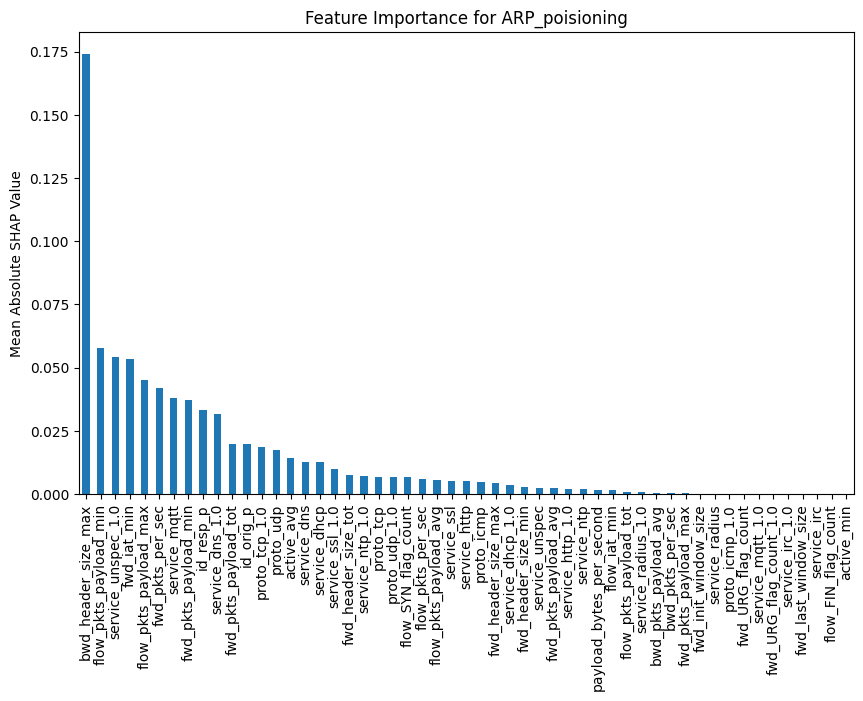

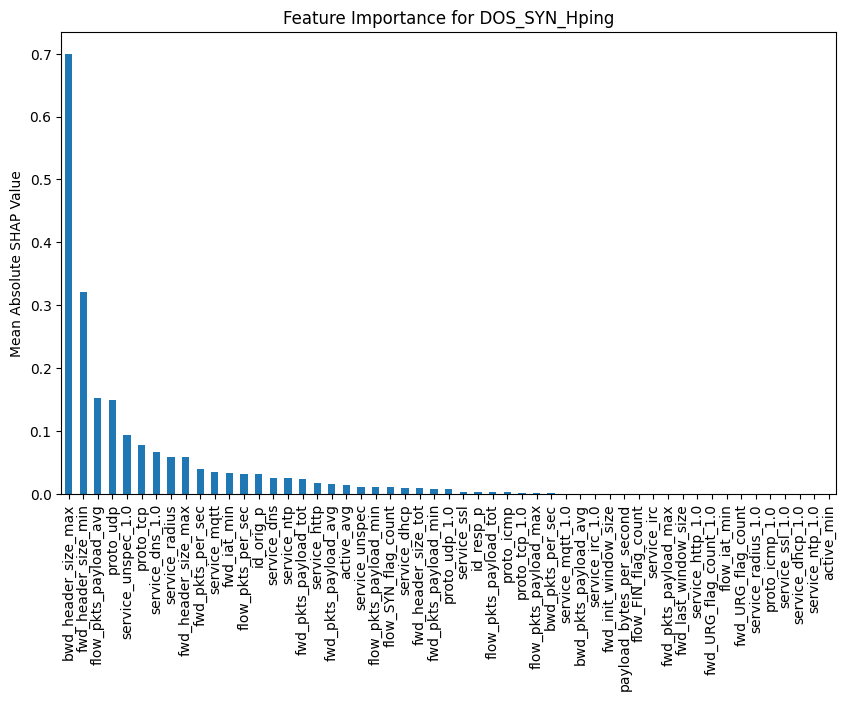

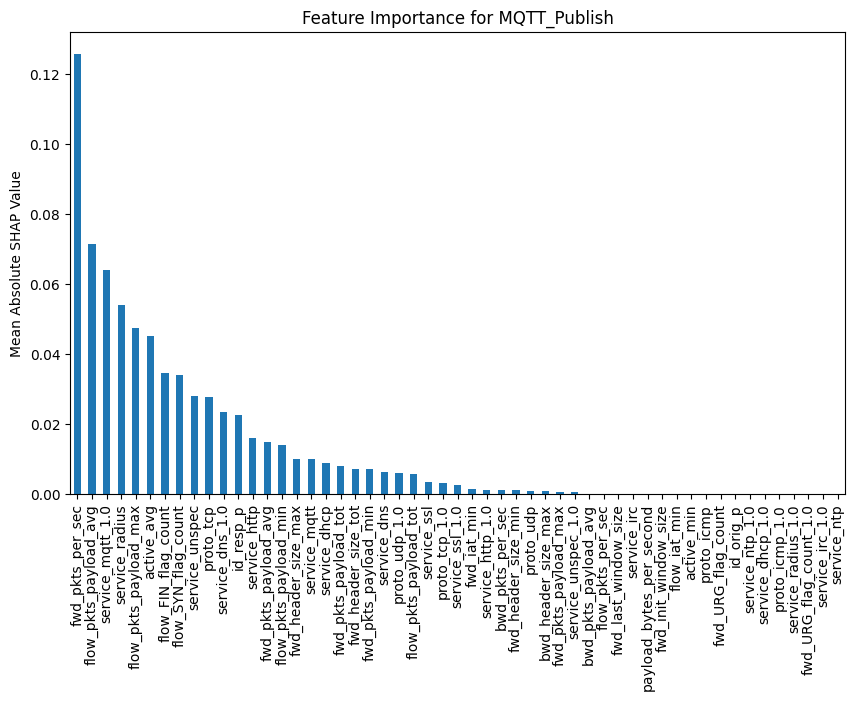

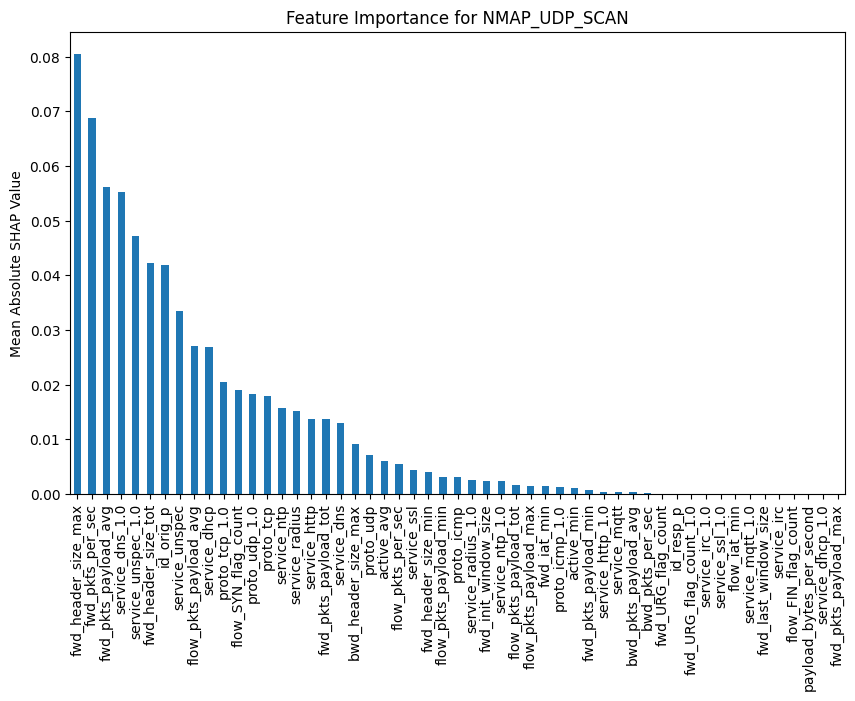

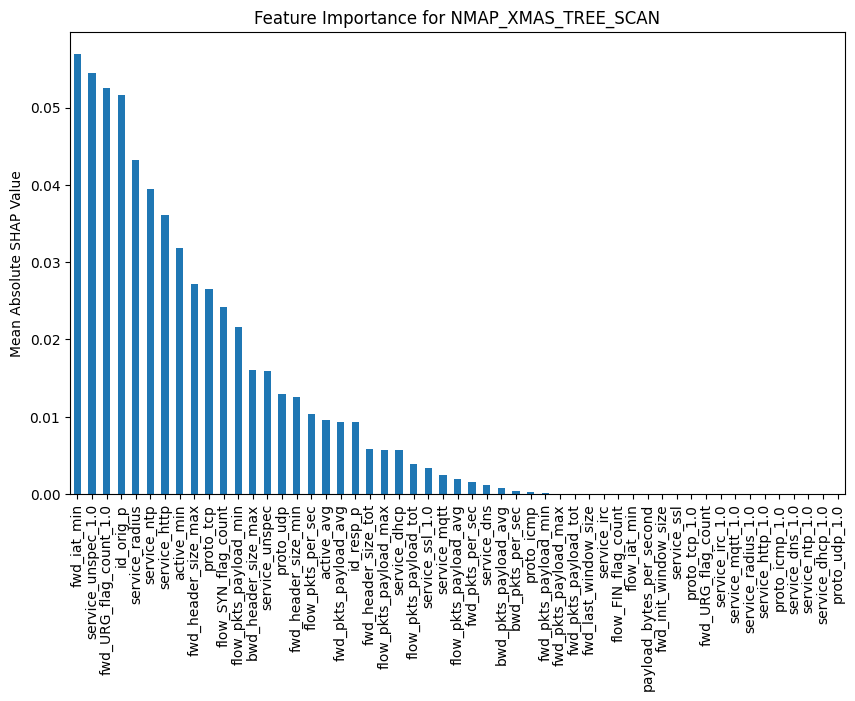

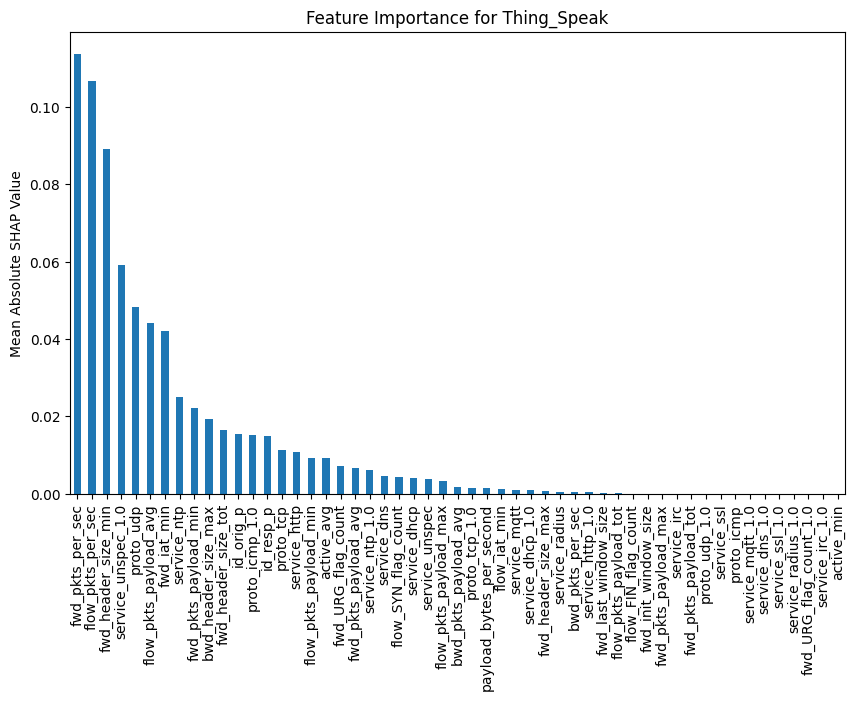

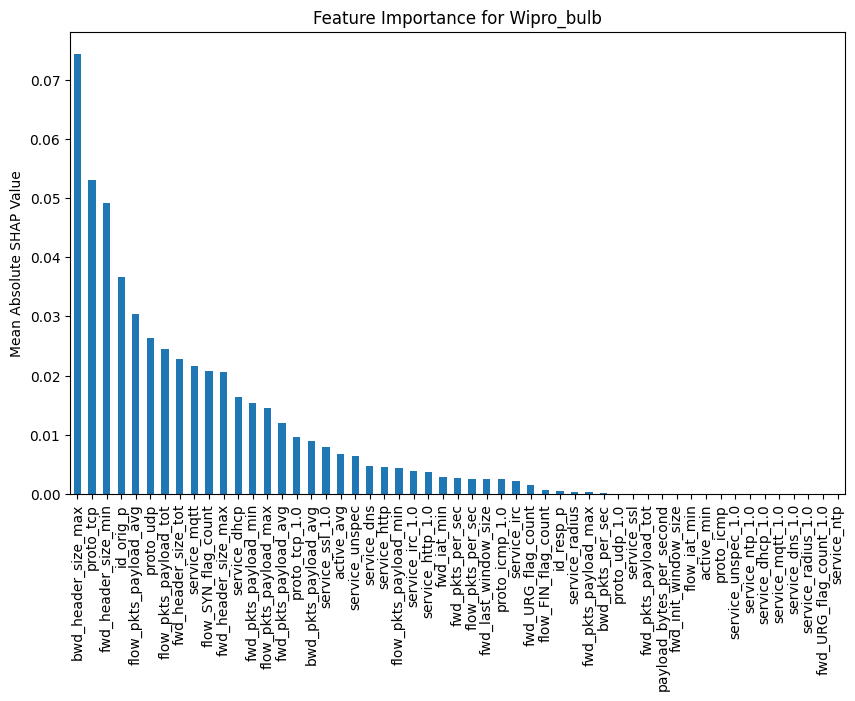

In [0]:
# Group by 'class' and then compute the mean absolute SHAP value for each feature within each class
grouped_shap = shap_df.groupby('class').mean().abs()

# Loop through each class to create a plot
for class_label, shap_values in grouped_shap.iterrows():
    # Sort the features by importance
    shap_values_sorted = shap_values.sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    shap_values_sorted.plot(kind='bar', title=f"Feature Importance for {class_label}")
    plt.ylabel('Mean Absolute SHAP Value')
    plt.show()

In [0]:
            for i, class_shap_values in enumerate(shap_values):
                plt.figure(figsize=(10, 6))
                shap.summary_plot(class_shap_values, data_processed, feature_names = all_feature_names, plot_type='bar')
                plt.title(f"Feature Importance for Attack Type {i+1}")
                plt.tight_layout() 
                st.pyplot(plt)

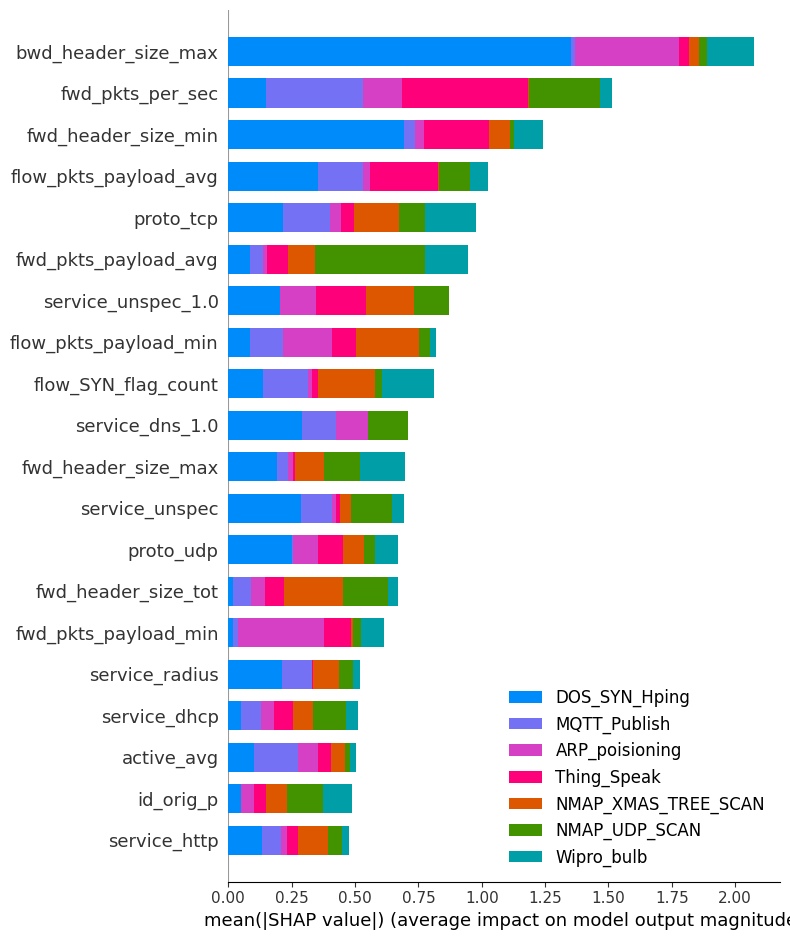

In [0]:
if shap_enabled:
    import shap

    # 'model' is in pipeline and the tree-based model is the last step in the pipeline
    tree_model = model.named_steps['classifier']

    # Create a TreeExplainer with the extracted tree-based model
    explainer = shap.TreeExplainer(tree_model)

    # Now you can calculate the SHAP values
    shap_values = explainer.shap_values(X_val_processed)

    # And generate your summary plot
    shap.summary_plot(shap_values, pd.DataFrame(X_val_processed, columns=all_feature_names), class_names=model.classes_)


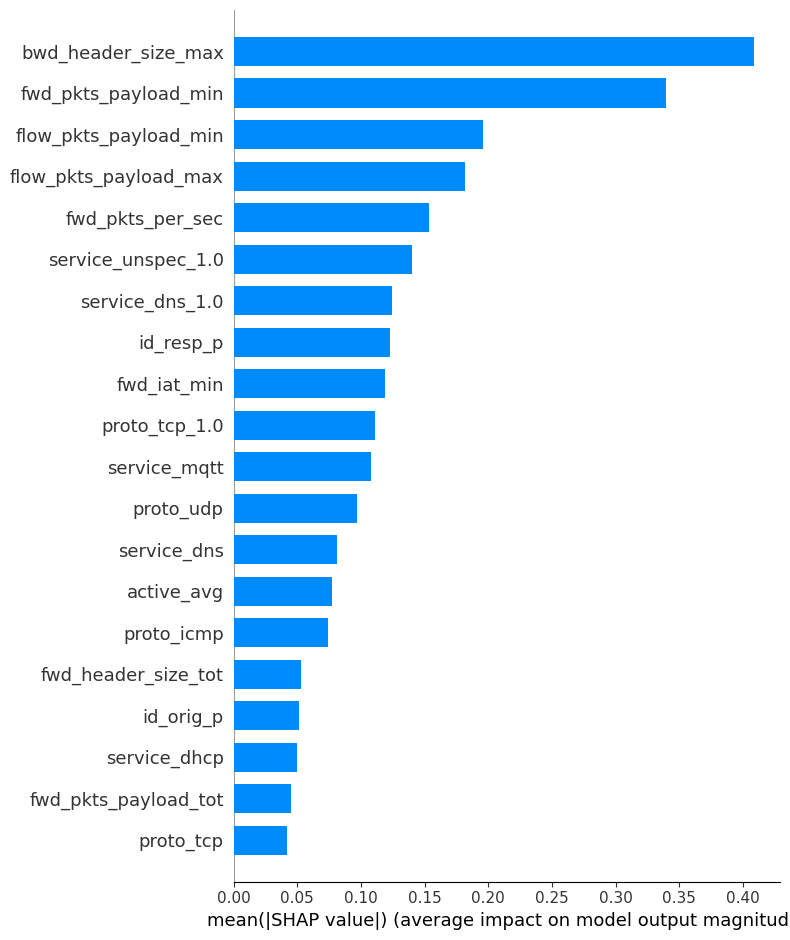

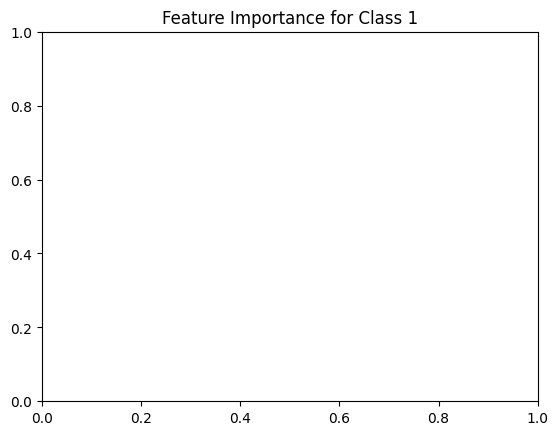

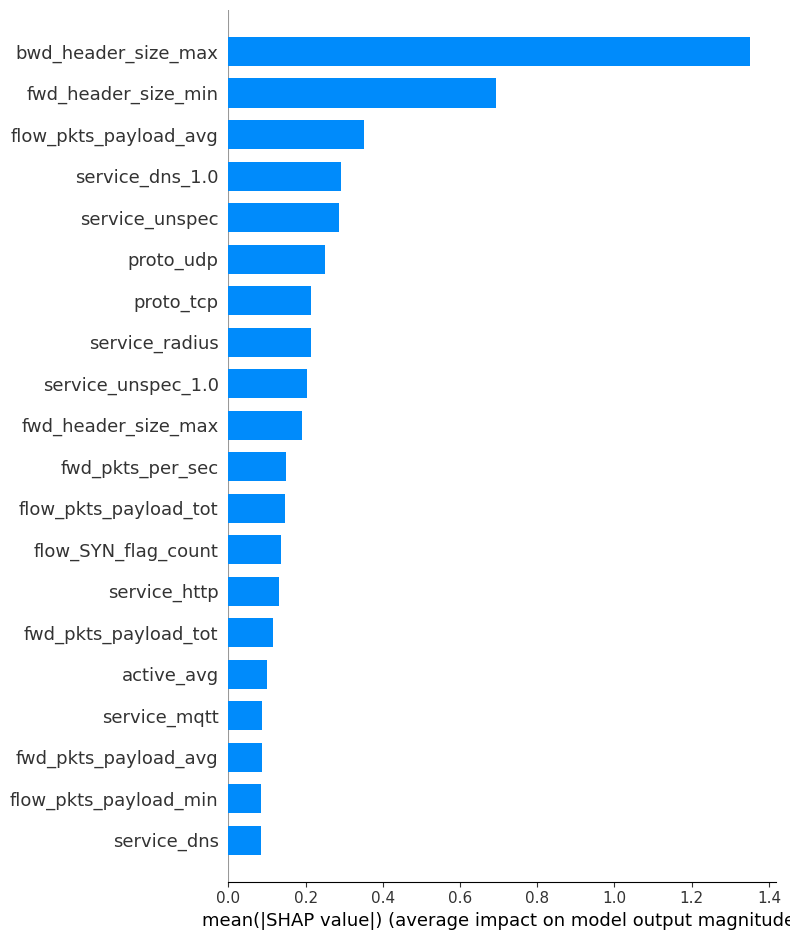

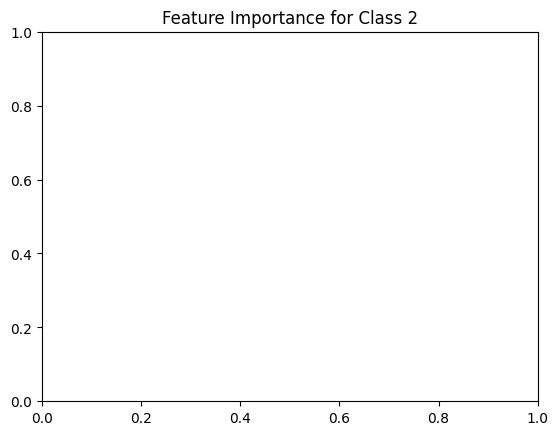

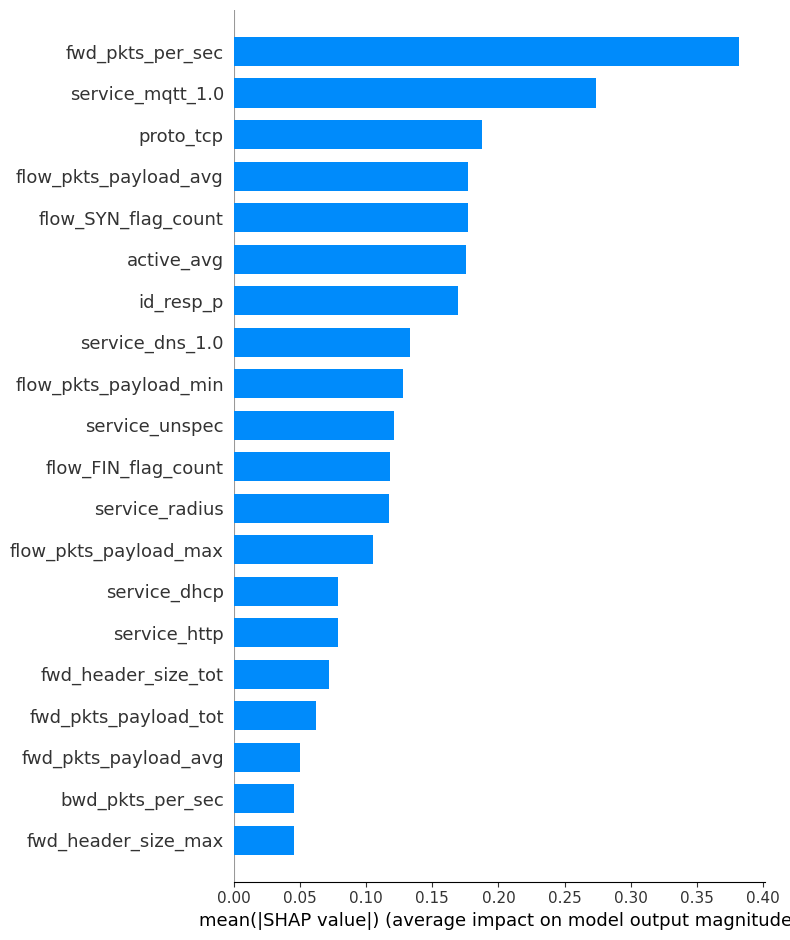

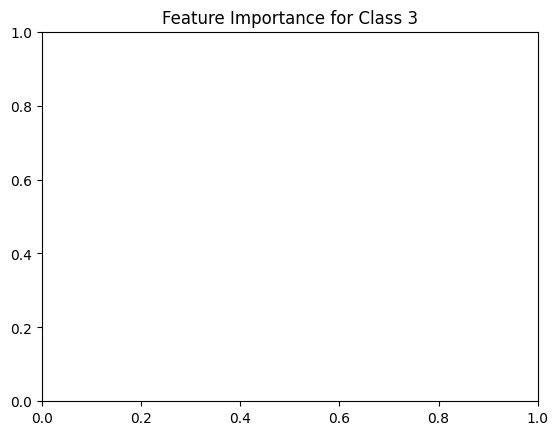

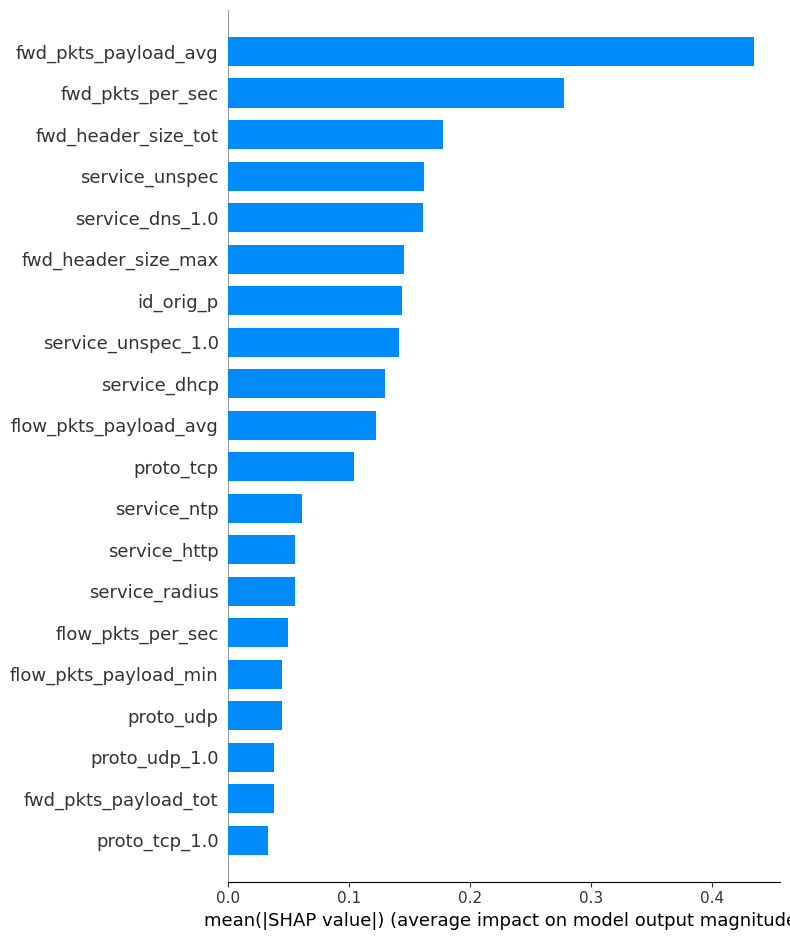

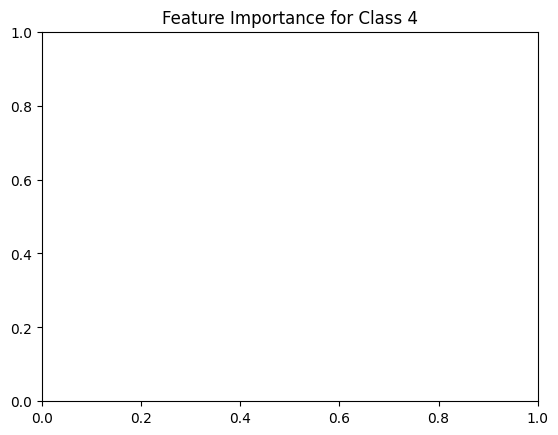

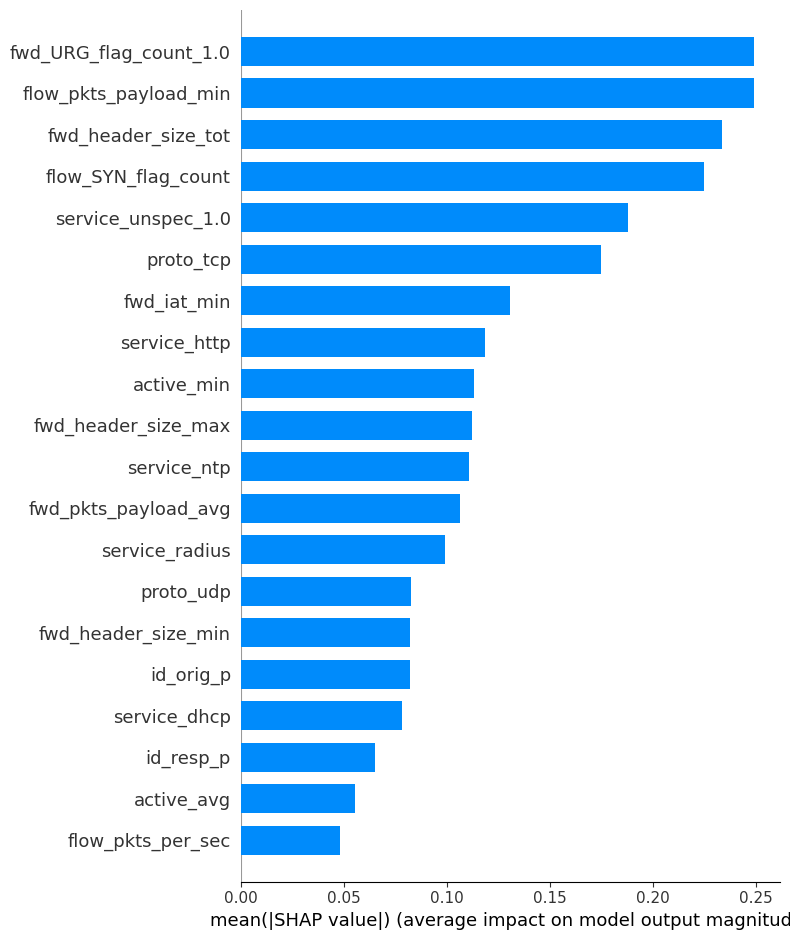

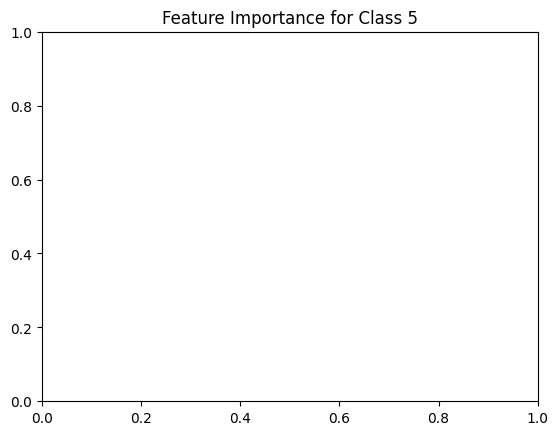

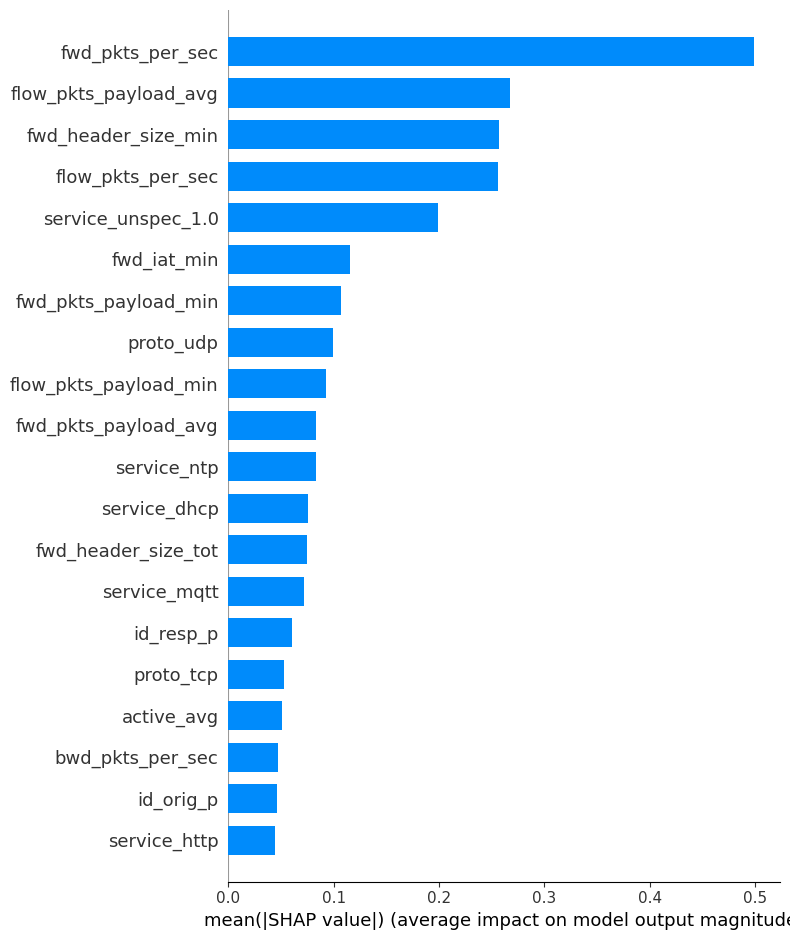

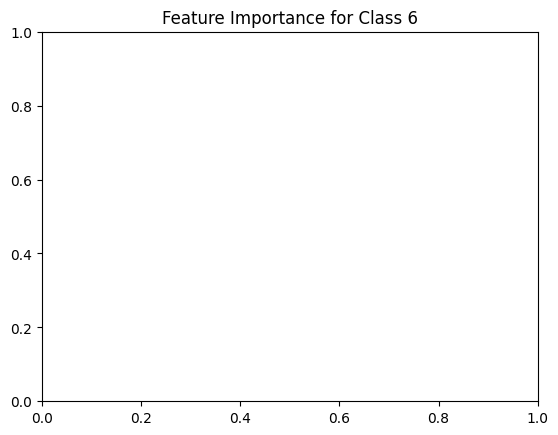

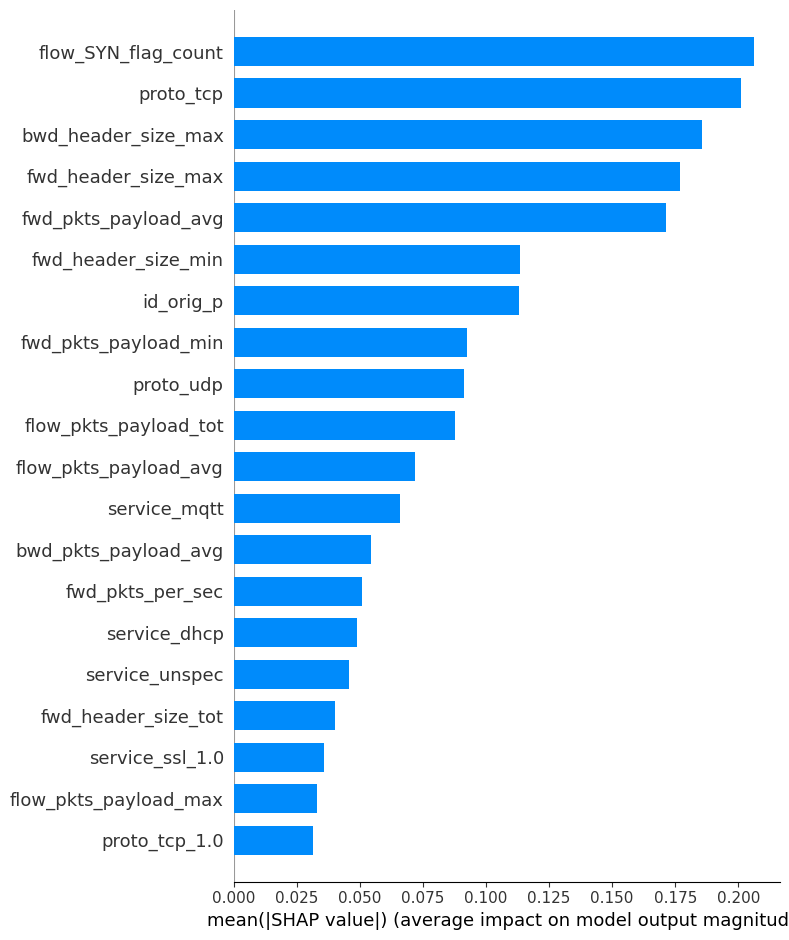

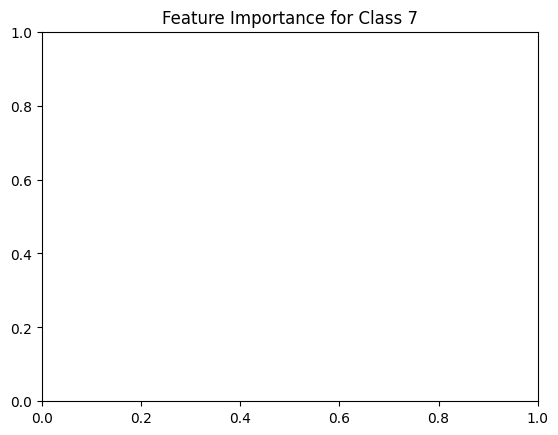

In [0]:

# Loop through the SHAP values for each class to plot the feature importance
for i, class_shap_values in enumerate(shap_values):
    shap.summary_plot(class_shap_values, pd.DataFrame(X_val_processed, columns=all_feature_names), feature_names=all_feature_names, plot_type="bar")
    plt.title(f"Feature Importance for Class {i+1}")
    plt.show()

## Confusion matrix for test data

We show the confusion matrix of the model on the test data.

For the plots evaluated on the training and the validation data, check the artifacts on the MLflow run page.

In [0]:
y_test.value_counts()

DOS_SYN_Hping          48767
Thing_Speak            15998
ARP_poisioning         12885
MQTT_Publish            6661
NMAP_XMAS_TREE_SCAN     4334
NMAP_UDP_SCAN           3766
Wipro_bulb              2489
Name: Attack_type, dtype: int64

In [0]:
synthetic_data_cgan = pd.read_csv('/dbfs/FileStore/m332479/GANs_forCyberSecurity/synthetic_data_cgan.csv')
synthetic_data_cgan

,fwd_init_window_size,id_resp_p,fwd_pkts_payload_avg,fwd_pkts_payload_min,fwd_URG_flag_count,flow_SYN_flag_count,fwd_header_size_min,fwd_header_size_max,flow_pkts_payload_tot,flow_pkts_payload_max,flow_iat_min,payload_bytes_per_second,fwd_last_window_size,id_orig_p,fwd_pkts_payload_max,flow_FIN_flag_count,active_min,flow_pkts_payload_avg,bwd_pkts_per_sec,bwd_pkts_payload_avg,flow_pkts_per_sec,fwd_header_size_tot,bwd_header_size_max,fwd_iat_min,fwd_pkts_per_sec,fwd_pkts_payload_tot,active_avg,flow_pkts_payload_min,Attack_type,service_dhcp,service_dns,service_http,service_irc,service_mqtt,service_ntp,service_radius,service_ssl,service_unspec,proto_icmp,proto_tcp,proto_udp
0,0.980190,0.011171,0.128255,0.000000,0.0,0.250163,0.726868,0.770068,0.001248,0.272436,0.000000e+00,0.000000,0.008253,0.904814,0.943199,0.199519,0.000000,0.252937,0.000466,0.246544,0.000000,0.009218,0.906527,0.000000,0.000301,0.002832,0.000939,0.000000,ARP_poisioning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.000668,0.000182,0.091300,0.109718,0.0,0.125057,0.454532,0.384420,0.000098,0.023674,0.000000e+00,0.250991,0.000839,0.891429,0.084789,0.000000,0.000000,0.051959,0.245865,0.000269,0.250167,0.000000,0.454220,0.000000,0.244073,0.000317,0.000000,0.000366,DOS_SYN_Hping,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.001129,0.000360,0.089921,0.108909,0.0,0.124991,0.454514,0.384245,0.000214,0.000449,5.582151e-07,0.188702,0.000650,0.991842,0.083563,0.000182,0.000000,0.051420,0.191963,0.000283,0.189358,0.000097,0.454932,0.000000,0.190848,0.000462,0.000287,0.000057,DOS_SYN_Hping,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.016030,0.020837,0.000000,0.000709,1.0,0.000110,0.454675,0.385278,0.000361,0.000178,0.000000e+00,0.000000,0.015803,0.883795,0.001065,0.099939,0.000000,0.000000,0.134390,0.000221,0.100579,0.000000,0.454476,0.000000,0.062977,0.000277,0.000000,0.000608,NMAP_XMAS_TREE_SCAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.976964,0.095704,0.003394,0.000000,0.0,0.249411,0.726556,0.768165,0.000270,0.007019,3.996393e-04,0.000000,0.006785,0.732175,0.025768,0.100650,0.007233,0.040496,0.000558,0.001075,0.000000,0.004541,0.906765,0.000000,0.000000,0.000381,0.004827,0.000000,ARP_poisioning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000743,0.000199,0.090777,0.109487,0.0,0.124786,0.454829,0.384903,0.000000,0.024105,1.719037e-04,0.249358,0.000960,0.553071,0.083449,0.000000,0.000000,0.051238,0.239715,0.000000,0.250873,0.000000,0.454435,0.000000,0.241307,0.000000,0.000000,0.000568,DOS_SYN_Hping,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
996,0.979608,0.013676,0.150996,0.000086,0.0,0.249090,0.727207,0.771722,0.001061,0.269883,0.000000e+00,0.000000,0.008480,0.624394,0.945513,0.197927,0.000384,0.263135,0.000000,0.058468,0.000000,0.009519,0.902478,0.000000,0.000000,0.002851,0.001430,0.000000,ARP_poisioning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
997,0.000359,0.000000,0.091063,0.109323,0.0,0.124886,0.454666,0.384166,0.000168,0.023929,2.985673e-04,0.799896,0.000583,0.752212,0.084602,0.000000,0.000386,0.052127,0.800735,0.000277,0.800426,0.000195,0.454958,0.000000,0.800656,0.000318,0.000680,0.000310,DOS_SYN_Hping,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
998,0.001075,0.000473,0.091331,0.109721,0.0,0.124630,0.454494,0.384612,0.000000,0.023910,1.683061e-04,0.998735,0.000768,0.068149,0.084767,0.000000,0.000223,0.051883,0.999547,0.000470,1.000000,0.000084,0.454522,0.000144,1.000000,0.000273,0.000000,0.001018,DOS_SYN_Hping,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [0]:
attacks = ['DOS_SYN_Hping', 'Thing_Speak', 'ARP_poisioning', 'MQTT_Publish', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN', 'Wipro_bulb']
synthetic_data_cgan = synthetic_data_cgan[synthetic_data_cgan['Attack_type'].isin(attacks)]
synthetic_data_cgan.Attack_type.value_counts()

DOS_SYN_Hping          498
Thing_Speak            158
ARP_poisioning         124
MQTT_Publish            66
NMAP_UDP_SCAN           42
NMAP_XMAS_TREE_SCAN     41
Wipro_bulb              29
Name: Attack_type, dtype: int64

Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l2 is set=3.2451254279815167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2451254279815167
[LightGBM] [Warning] lambda_l1 is set=4.257968453073029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.257968453073029


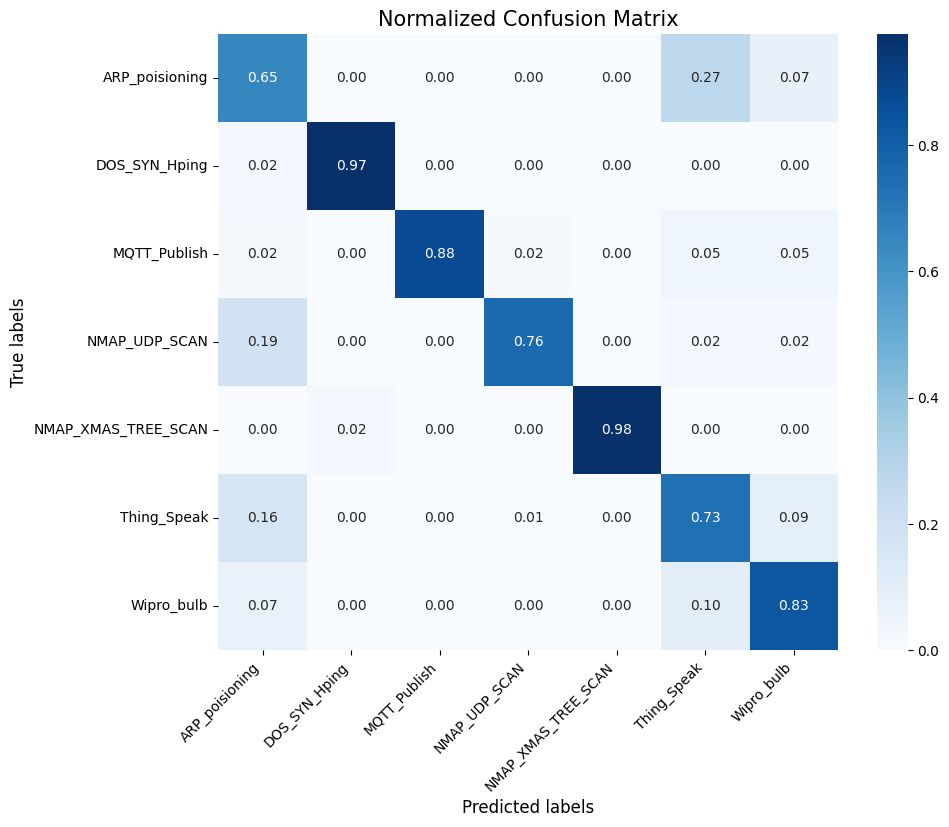

In [0]:

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

y = synthetic_data_cgan['Attack_type']
synthetic_data = synthetic_data_cgan.drop(['Attack_type'], axis=1)

pipeline_synthetic = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
])
pipeline_synthetic.fit(synthetic_data, y)

# Manually set the feature names for the 'cast_type' step, assuming it just converts types without changing the number or order of features
cast_type_feature_names = ["proto_udp", "service_http", "service_irc", "fwd_URG_flag_count", "service_radius", "proto_icmp", "service_ssl", "service_dns", "proto_tcp", "service_mqtt", "service_dhcp", "service_ntp", "service_unspec"]

# Get the feature names for the one-hot encoded features
onehot_feature_names = pipeline_val.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out(cast_type_feature_names)

# Combine the one-hot encoded feature names with the numerical feature names
# Assuming numerical features are passed through as-is (since they are just scaled), append their original names
numerical_feature_names = ["active_avg", "id_resp_p", "fwd_pkts_payload_avg", "fwd_pkts_per_sec", "id_orig_p", "service_radius", "flow_pkts_payload_tot", "service_dns", "fwd_header_size_tot", "service_dhcp", "flow_pkts_payload_min", "bwd_pkts_per_sec", "flow_pkts_per_sec", "active_min", "service_http", "fwd_header_size_max", "flow_pkts_payload_max", "bwd_pkts_payload_avg", "flow_SYN_flag_count", "proto_tcp", "fwd_header_size_min", "service_mqtt", "bwd_header_size_max", "fwd_pkts_payload_min", "fwd_iat_min", "service_unspec", "flow_pkts_payload_avg", "proto_udp", "fwd_URG_flag_count", "proto_icmp", "service_ssl", "flow_iat_min", "fwd_pkts_payload_tot", "fwd_last_window_size", "service_irc", "flow_FIN_flag_count", "payload_bytes_per_second", "fwd_init_window_size", "fwd_pkts_payload_max", "service_ntp"]

# Combine all the feature names
all_feature_names = list(onehot_feature_names) + numerical_feature_names

synthetic_data_processed = pipeline_synthetic.transform(synthetic_data)
synthetic_data_processed = pd.DataFrame(synthetic_data_processed, columns=all_feature_names)
pred = tree_model.predict(synthetic_data_processed) 
# Compute the confusion matrix
cm = confusion_matrix(y, pred)

# Normalize the confusion matrix
cm_normalized = normalize(cm, axis=1, norm='l1')


# Dictionary mapping from encoded label integers to string representations
label_dict = {
    1: "DOS_SYN_Hping",
    5: "Thing_Speak",
    0: "ARP_poisioning",
    2: "MQTT_Publish",
    4: "NMAP_XMAS_TREE_SCAN",
    3: "NMAP_UDP_SCAN",
    6: "Wipro_bulb"
}

# Creating a list of labels in the correct order
labels = [label_dict[i] for i in sorted(label_dict.keys())]

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f',
                 xticklabels=labels, yticklabels=labels)

# Labels, title, and ticks
label_font = {'size': '12'}
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Normalized Confusion Matrix', fontdict={'size': '15'})
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0)
plt.show()


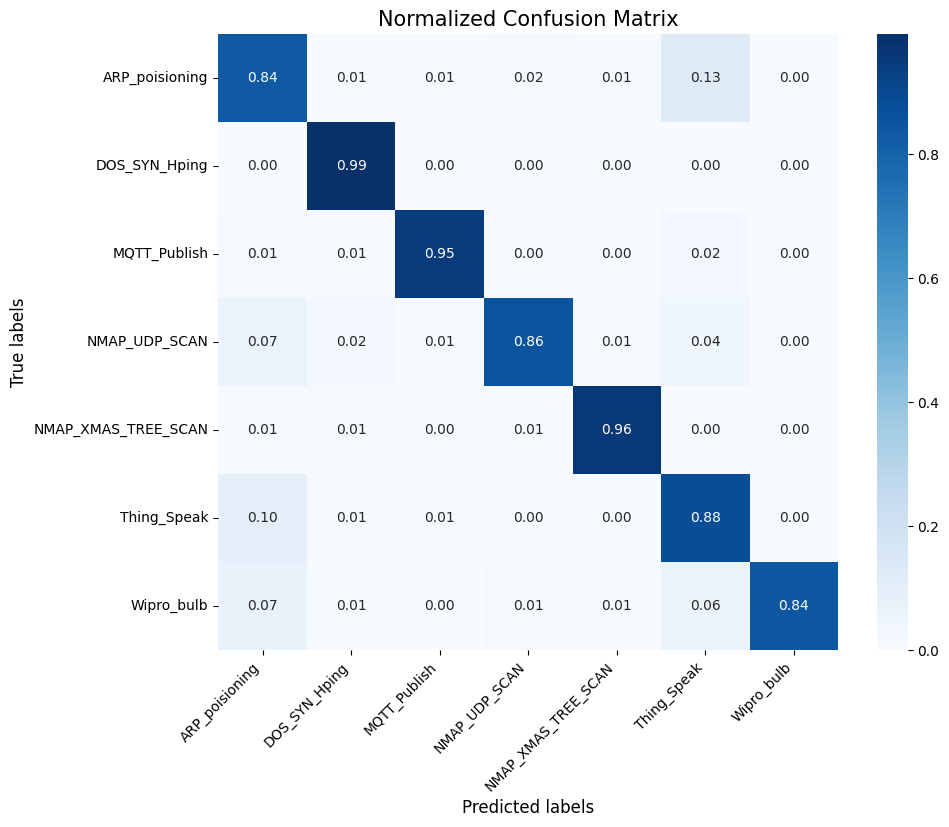

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

pipeline_test = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
])
pipeline_test.fit(X_train, y_train)
X_test_processed = pipeline_val.transform(X_test)
y_pred = tree_model.predict(X_test_processed ) 
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = normalize(cm, axis=1, norm='l1')


# Dictionary mapping from encoded label integers to string representations
label_dict = {
    1: "DOS_SYN_Hping",
    5: "Thing_Speak",
    0: "ARP_poisioning",
    2: "MQTT_Publish",
    4: "NMAP_XMAS_TREE_SCAN",
    3: "NMAP_UDP_SCAN",
    6: "Wipro_bulb"
}

# Creating a list of labels in the correct order
labels = [label_dict[i] for i in sorted(label_dict.keys())]

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f',
                 xticklabels=labels, yticklabels=labels)

# Labels, title, and ticks
label_font = {'size': '12'}
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Normalized Confusion Matrix', fontdict={'size': '15'})
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0)
plt.show()


In [0]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_test) 
# Compute the confusion matrix

# Extracting unique labels from the test set and predictions
unique_labels = np.unique(y_test)

            
# Get the labels from the label encoding dictionary
label_dict = {v: k for k, v in label_encoded_dict.items()}
# Mapping the unique labels to their original names
labels = [label_dict[label] for label in unique_labels]
            
# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f',
    xticklabels=labels, yticklabels=labels)

# Labels, title, and ticks
label_font = {'size': '12'}
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Normalized Confusion Matrix', fontdict={'size': '15'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

In [0]:
import joblib
joblib.dump(tree_model, "/dbfs/FileStore/m332479/GANs_forCyberSecurity/models/lightGBM_multiclass_classifier.joblib")

['/dbfs/FileStore/m332479/GANs_forCyberSecurity/models/lightGBM_multiclass_classifier.joblib']

## Inference
[The MLflow Model Registry](https://docs.databricks.com/applications/mlflow/model-registry.html) is a collaborative hub where teams can share ML models, work together from experimentation to online testing and production, integrate with approval and governance workflows, and monitor ML deployments and their performance. The snippets below show how to add the model trained in this notebook to the model registry and to retrieve it later for inference.

> **NOTE:** The `model_uri` for the model already trained in this notebook can be found in the cell below

### Register to Model Registry
```
model_name = "Example"

model_uri = f"runs:/{ mlflow_run.info.run_id }/model"
registered_model_version = mlflow.register_model(model_uri, model_name)
```

### Load from Model Registry
```
model_name = "Example"
model_version = registered_model_version.version

model_uri=f"models:/{model_name}/{model_version}"
model = mlflow.pyfunc.load_model(model_uri=model_uri)
model.predict(input_X)
```

### Load model without registering
```
model_uri = f"runs:/{ mlflow_run.info.run_id }/model"

model = mlflow.pyfunc.load_model(model_uri=model_uri)
model.predict(input_X)
```

In [0]:
# model_uri for the generated model
print(f"runs:/{ mlflow_run.info.run_id }/model")

runs:/88c78f6fdbe34a0d8f7460a4df872b66/model


## Confusion matrix for validation data

We show the confusion matrix of the model on the validation data.

For the plots evaluated on the training and the test data, check the artifacts on the MLflow run page.

In [0]:
# Click the link to see the MLflow run page
displayHTML(f"<a href=#mlflow/experiments/1409232751952184/runs/{ mlflow_run.info.run_id }/artifactPath/model> Link to model run page </a>")

In [0]:
import uuid
from IPython.display import Image

# Create temp directory to download MLflow model artifact
eval_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(eval_temp_dir, exist_ok=True)

# Download the artifact
eval_path = mlflow.artifacts.download_artifacts(run_id=mlflow_run.info.run_id, dst_path=eval_temp_dir)

2024/04/04 04:33:11 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


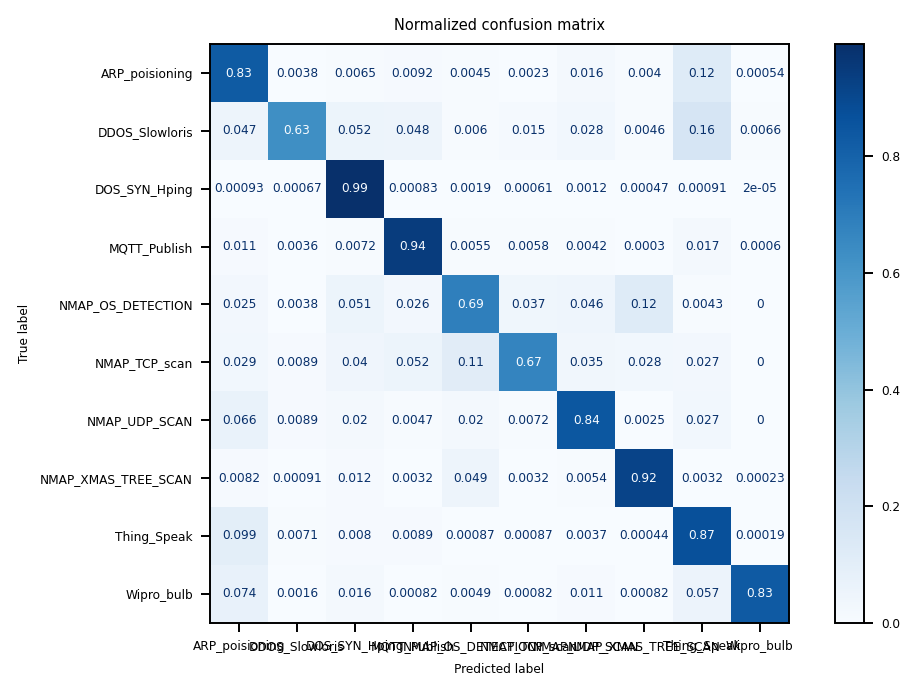

In [0]:
eval_confusion_matrix_path = os.path.join(eval_path, "val_confusion_matrix.png")
display(Image(filename=eval_confusion_matrix_path))